In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import sqrt, pi
import seaborn as sns; sns.set_theme()
from canny import *

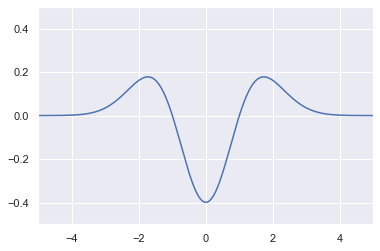

In [2]:
# Question 2a
x = np.arange(-5, 5, 0.01)
coeff = (np.square(x)-1)*(1/sqrt(2*pi))
y = (coeff)*np.exp((-1/2)*np.square(x))
plt.plot(x, y)
plt.axis([-5, 5, -0.5, 0.5])
plt.show()

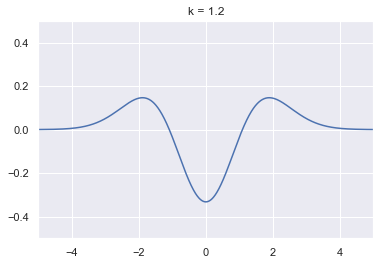

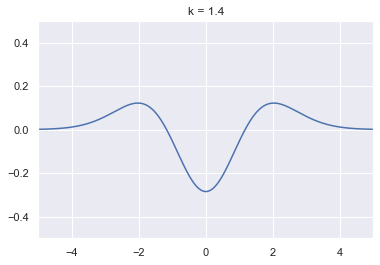

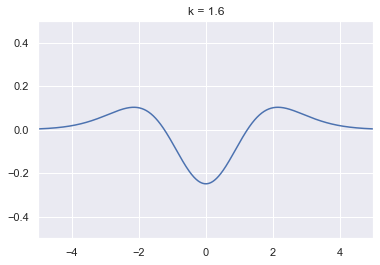

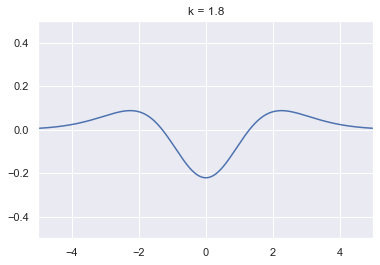

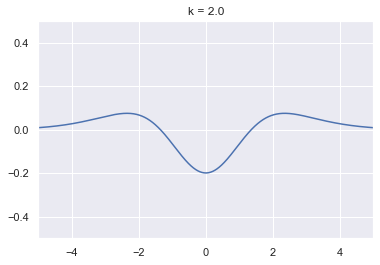

In [3]:
def gaussian(k):
    return np.exp(np.square(x) / (-2*k*k)) / (sqrt(2*pi)*k)

for k in [1.2, 1.4, 1.6, 1.8, 2.0]:
    x = np.arange(-5, 5, 0.01)
    y = (gaussian(k) - gaussian(1)) / (k-1)
    plt.plot(x, y)
    plt.axis([-5, 5, -0.5, 0.5])
    plt.title("k = " + str(k))
    plt.show()

In [4]:
# Question 6
sigma = 1
k = cv2.getGaussianKernel(5,sigma)
print(k)

[[0.05448868]
 [0.24420134]
 [0.40261995]
 [0.24420134]
 [0.05448868]]


[[1.5915494e-01 9.6532352e-02 2.1539280e-02 0.0000000e+00 1.7680518e-03
  2.1539280e-02 9.6532352e-02]
 [9.6532352e-02 5.8549833e-02 1.3064234e-02 0.0000000e+00 1.0723775e-03
  1.3064234e-02 5.8549833e-02]
 [2.1539280e-02 1.3064234e-02 2.9150245e-03 0.0000000e+00 2.3927978e-04
  2.9150245e-03 1.3064234e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.7680518e-03 1.0723775e-03 2.3927978e-04 0.0000000e+00 1.9641280e-05
  2.3927978e-04 1.0723775e-03]
 [2.1539280e-02 1.3064234e-02 2.9150245e-03 0.0000000e+00 2.3927978e-04
  2.9150245e-03 1.3064234e-02]
 [9.6532352e-02 5.8549833e-02 1.3064234e-02 0.0000000e+00 1.0723775e-03
  1.3064234e-02 5.8549833e-02]]
(768, 1024)


/opt/anaconda3/envs/cos429/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/cos429/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


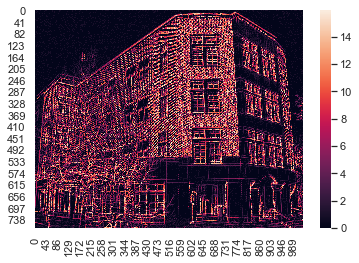

In [5]:
img = cv2.imread('example_images/csbldg.jpg', 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow('image_gray', gray)
cv2.imwrite("test-out.jpeg", gray)


# finding the derivative of a function convolved with a Gaussian is the same
# as convolving with the derivative of a Gaussian

def gauss(sigma): # get kernel of gaussian, sizes depends on sigma
    half_size = 3*sigma

    dim = 2*half_size+1

    k = np.zeros((dim, dim), np.single)

    for i in range(-half_size, half_size, 1):
        for j in range(-half_size, half_size, 1):
            k[i,j] = np.exp((i**2 + j**2) / (-2*sigma)) / (sigma*2*pi)

    return k

kernel = gauss(1)

# deriv of gaussian in x direction
print(kernel)
xconv = np.array([[-1, 1, 0]])
dx = cv2.filter2D(kernel,-1,xconv)
# print("dx", dx)
fx = cv2.filter2D(gray,-1,dx)
# print("fx", fx)
# print(fx.shape)
cv2.imwrite("fx.jpeg", fx)

# deriv of gaussian in y direction
yconv = np.array([[-1], [1], [0]])
dy = cv2.filter2D(kernel,-1,yconv)
# print("dy", dy)
fy = cv2.filter2D(gray,-1,dy)
# print("fy", fy)
print(fy.shape)
cv2.imwrite("fy.jpeg", fy)

# Computer edge strength and edge orientation at each pixel.
def edge_str_ori(fx, fy, img):
    F = np.sqrt(np.square(fx) + np.square(fy))
    div = fy / fx
    D = np.arctan(div)
#     print(orient)
    D = np.where(D > 0, D, D+pi)
#     print(orient)
    return F, D

F, D = edge_str_ori(fx, fy, gray)
ax1 = sns.heatmap(F)


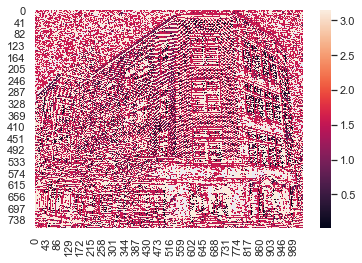

In [6]:
ax2 = sns.heatmap(D)

[[0.         0.         0.         ... 0.         1.57079633 0.        ]
 [0.         0.         0.         ... 0.78539816 1.57079633 0.        ]
 [0.         0.         0.         ... 2.35619449 1.57079633 1.57079633]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.35619449]
 [0.         0.         0.         ... 1.57079633 1.57079633 1.57079633]]


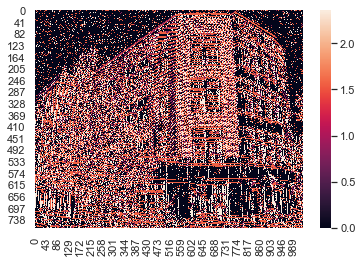

In [7]:
# For each pixel, find the direction 𝐷∗∈0,𝜋/4,𝜋/2,3𝜋/4 that is closest to the orientation 𝐷 at that pixel.
angles = np.array([0, pi/4, pi/2, 3*pi/4])
D_prime = np.zeros(D.shape)
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D_prime[i][j] = angles[np.abs(angles - D[i][j]).argmin()]
print(D_prime)
ax3 = sns.heatmap(D_prime)

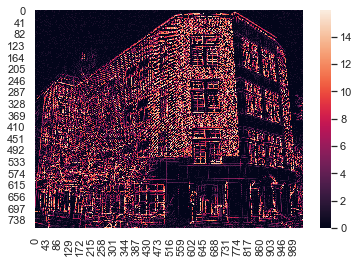

In [8]:
# If the edge strength 𝐹(𝑥,𝑦) is smaller than at least one of its neighbors along 𝐷∗, 
# set 𝐼(𝑥,𝑦)=0, else set 𝐼(𝑥,𝑦)=𝐹(𝑥,𝑦).

I = np.zeros(gray.shape)
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if D_prime[i][j] == 0:
            n1, n2 = (i, max(0,j-1)), (i, min(I.shape[1]-1,j+1))
        elif D_prime[i][j] == pi/4:
            n1, n2 = (max(0,i-1), min(I.shape[1]-1,j+1)), (min(I.shape[0]-1, i+1), max(0,j-1))
        elif D_prime[i][j] == pi/2:
            n1, n2 = (max(0,i-1), j), (min(I.shape[0]-1, i+1), j)
        else:
            n1, n2 = (max(0,i-1), max(0,j-1)), (min(I.shape[0]-1, i+1), min(I.shape[1]-1,j+1))
            
        if F[i][j] > F[n1] or F[i][j] > F[n2]:
            I[i][j] = F[i][j]
ax4 = sns.heatmap(I)

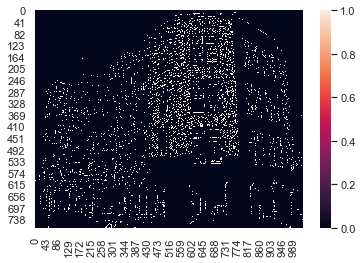

In [9]:
edgemap = np.zeros(I.shape)
I_normal = I / np.amax(I)
th = 0.8
tl = 0.7
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if I_normal[i][j] > th:
            edgemap[i][j] = 1
            to_check = [(i,j)]
            while(to_check):
                p = to_check.pop(0)
                if edgemap[p] == 0:
                    if D_prime[p[0]][p[1]] == 0:
                        n1, n2 = (max(0,p[0]-1), p[1]), (min(I.shape[0]-1, p[0]+1), p[1])
                    elif D_prime[p[0]][p[1]] == pi/4:
                        n1, n2 = (max(0,p[0]-1), max(0,p[1]-1)), (min(I.shape[0]-1, p[0]+1), min(I.shape[1]-1,p[1]+1))
                    elif D_prime[p[0]][p[1]] == pi/2:
                        n1, n2 = (p[0], max(0,p[1]-1)), (p[0], min(I.shape[1]-1,p[1]+1))
                    else:
                        n1, n2 = (max(0,p[0]-1), min(I.shape[1]-1,p[1]+1)), (min(I.shape[0]-1, p[0]+1), max(0,p[1]-1))
                    if I[n1] > tl:
                        to_check.append(n1)
                        edgemap[n1] = 1
                    if I[n2] > tl:
                        to_check.append(n2)
                        edgemap[n2] = 1
                    
ax5 = sns.heatmap(edgemap)

/Users/kwantlin/github/student-assignment-1/canny.py:63: RuntimeWarning: divide by zero encountered in true_divide
  div = Fy / Fx
/Users/kwantlin/github/student-assignment-1/canny.py:63: RuntimeWarning: invalid value encountered in true_divide
  div = Fy / Fx


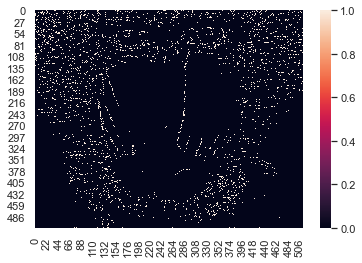

In [10]:
img_mandrill = cv2.imread('example_images/mandrill.jpg', 1)
gray_mandrill = cv2.cvtColor(img_mandrill, cv2.COLOR_BGR2GRAY)
edgemap_mandrill = cannyEdgeDetection(gray_mandrill, sigma, 0.2, 0.8)
ax6 = sns.heatmap(edgemap_mandrill)

In [13]:
img_cs = cv2.imread('example_images/csbldg.jpg', 1)
gray_cs = cv2.cvtColor(img_cs, cv2.COLOR_BGR2GRAY)
edgemap_cs = cannyEdgeDetection(gray_cs, sigma, 0.2, 0.8)
ax6 = sns.heatmap(edgemap_cs)
# cv2.imshow('image_gray', edgemap_cs)